In [1]:
%matplotlib inline

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model

import os

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/bean-disease-dataset/Bean_Dataset",
    seed=85,
    # To randomly shuffle all the images
    shuffle=True,
    # Input image size
    image_size=(256, 256),
    # Set batch size to 32
    batch_size=32
)

Found 990 files belonging to 3 classes.


2023-01-24 03:39:33.402482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 03:39:33.487769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 03:39:33.488514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 03:39:33.490943: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
bean_classes = dataset.class_names
bean_classes

['angular_leaf_spot', 'bean_rust', 'healthy']

2023-01-24 03:39:36.094423: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


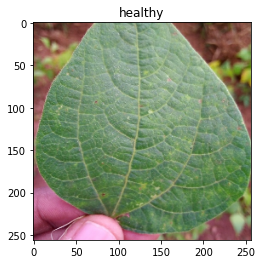

In [4]:
# Printing an image
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(bean_classes[labels_batch[0]])

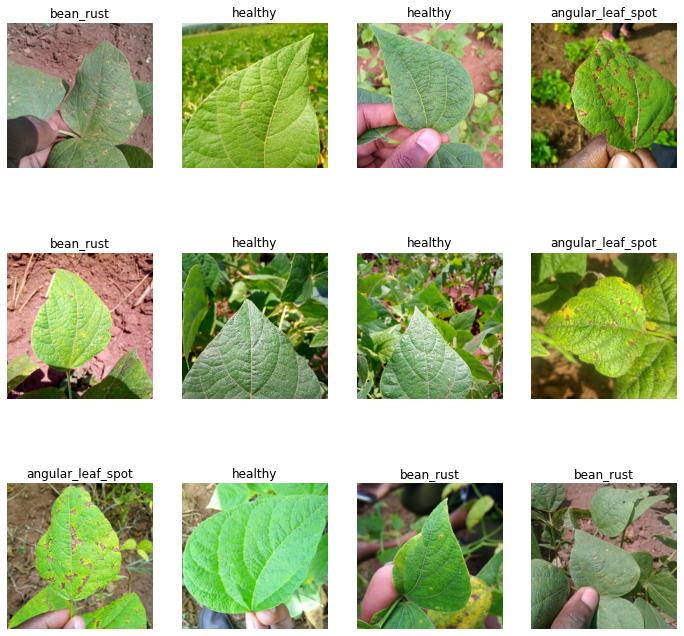

In [5]:
# First 12 images in the a batch
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(bean_classes[labels_batch[i]])
        plt.axis("off")

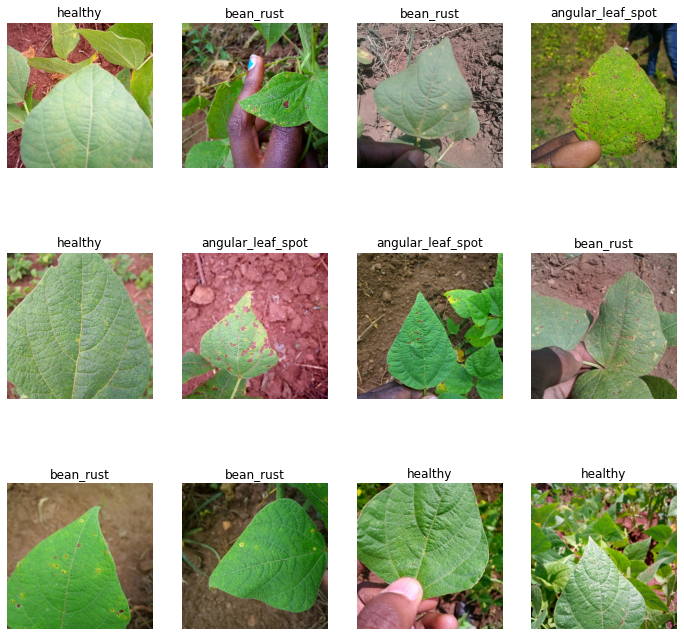

In [6]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(bean_classes[labels_batch[i]])
        plt.axis("off")

In [7]:
# Print the number of batches 
# In our dataset
len(dataset)

31

In [8]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    """
    Takes a dataset and splits it into train, validation and test sets. 
    """
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=85)
    
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    
    train_set = dataset.take(train_size)    
    val_set = dataset.skip(train_size).take(val_size)
    test_set = dataset.skip(train_size).skip(val_size)
    
    return train_set, val_set, test_set

In [9]:
train_set, val_set, test_set = get_dataset_partitions_tf(dataset)

In [10]:
# Visualize the lenght of our splits
len(train_set), len(val_set), len(test_set)

(24, 3, 4)

In [11]:
print("Configuring the dataset for better performance")
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Configuring the dataset for better performance


In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
# Apply data augmentation to train dataset

train_set = train_set.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import callbacks
filepath="unet_xception_encoder_resdual_decoder3.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)
callbacks_list = [checkpoint]

In [18]:
input_shape = ( 256, 256, 3)
n_classes = 3
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history1 = model_0.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=120,
    callbacks = callbacks_list,
)

Shape after base_model: (None, 8, 8, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Epoch 1/120
24/24 [==============================] - 12s 331ms/step - loss: 1.2321 - accuracy: 0.4922 - val_loss: 0.8518 - val_accuracy: 0.6562

Epoch 00001: val_accuracy improved from -inf to 0.65625, saving model to unet_xception_encoder_resdual_decoder3.h5
Epoch 2/120
24/24 [==============================] - 7s 277ms/step - loss: 0.7151 - accuracy: 0.7128 - val_loss: 0.7076 - val_accuracy: 0.7500

Epoch 00002: val_accuracy improved from 0.65625 to 0.75000, saving model to unet_xception_encoder_resdual_decoder3.h5
Epoch 3/120
24/24 [==============================] - 7s 271ms/step - loss: 0.5871 - accuracy: 0.7742 - val_loss: 0.6525 - val_accuracy: 0.7500

Epoch 00003: val_accuracy did not improve from 0.75000
Epoch 4/120
24/24 [==============================] - 6s 255ms/step - loss: 0.5346 - accuracy: 0.8055 - val_loss: 0.5805 - val_accuracy: 0.7812

Epoch 00004: val_accuracy improved from 0.75000

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import callbacks
filepath="eff7.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)
callbacks_list2 = [checkpoint]

In [20]:
input_shape = ( 256, 256, 3)
n_classes = 3
# 1. Create base model with tf.keras.applications
base_model2 = tf.keras.applications.EfficientNetB7(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model2.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model2(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_2 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history2 = model_2.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=120,
    callbacks = callbacks_list2,
)

258088960/258076736 [==============================] - 1s 0us/step
Shape after base_model: (None, 8, 8, 2560)
After GlobalAveragePooling2D(): (None, 2560)
Epoch 1/120
24/24 [==============================] - 32s 624ms/step - loss: 1.0872 - accuracy: 0.6175 - val_loss: 0.7299 - val_accuracy: 0.7708

Epoch 00001: val_accuracy improved from -inf to 0.77083, saving model to eff7.h5
Epoch 2/120
24/24 [==============================] - 11s 467ms/step - loss: 0.6065 - accuracy: 0.8029 - val_loss: 0.5623 - val_accuracy: 0.8333

Epoch 00002: val_accuracy improved from 0.77083 to 0.83333, saving model to eff7.h5
Epoch 3/120
24/24 [==============================] - 11s 471ms/step - loss: 0.4936 - accuracy: 0.8368 - val_loss: 0.4944 - val_accuracy: 0.8438

Epoch 00003: val_accuracy improved from 0.83333 to 0.84375, saving model to eff7.h5
Epoch 4/120
24/24 [==============================] - 11s 458ms/step - loss: 0.4553 - accuracy: 0.8499 - val_loss: 0.4620 - val_accuracy: 0.8542

Epoch 00004: val

In [21]:
scores2 = model_2.evaluate(test_set)

4/4 [==============================] - 4s 269ms/step - loss: 0.1095 - accuracy: 0.9609


In [22]:
scores2

[0.10947999358177185, 0.9609375]

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import callbacks
filepath="res502.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)
callbacks_list3 = [checkpoint]

In [30]:
input_shape = ( 256, 256, 3)
n_classes = 3
# 1. Create base model with tf.keras.applications
base_model3 = tf.keras.applications.resnet50.ResNet50(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model3.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model3(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_3 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_3.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history3 = model_3.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=500,
    callbacks = callbacks_list3,
)

Shape after base_model: (None, 8, 8, 2048)
After GlobalAveragePooling2D(): (None, 2048)
Epoch 1/500
24/24 [==============================] - 11s 320ms/step - loss: 1.2041 - accuracy: 0.4478 - val_loss: 0.7316 - val_accuracy: 0.7188

Epoch 00001: val_accuracy improved from -inf to 0.71875, saving model to res502.h5
Epoch 2/500
24/24 [==============================] - 7s 273ms/step - loss: 0.6008 - accuracy: 0.7611 - val_loss: 0.5503 - val_accuracy: 0.8021

Epoch 00002: val_accuracy improved from 0.71875 to 0.80208, saving model to res502.h5
Epoch 3/500
24/24 [==============================] - 7s 271ms/step - loss: 0.4613 - accuracy: 0.8381 - val_loss: 0.4460 - val_accuracy: 0.8646

Epoch 00003: val_accuracy improved from 0.80208 to 0.86458, saving model to res502.h5
Epoch 4/500
24/24 [==============================] - 7s 302ms/step - loss: 0.4127 - accuracy: 0.8551 - val_loss: 0.3984 - val_accuracy: 0.8854

Epoch 00004: val_accuracy improved from 0.86458 to 0.88542, saving model to res5

In [31]:
# Evaluate model performance on test set
scores = model_3.evaluate(test_set)

4/4 [==============================] - 0s 72ms/step - loss: 0.0363 - accuracy: 0.9844


In [32]:
scores

[0.03634794428944588, 0.984375]

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(range(120), acc, color='green', label='Training Accuracy')
plt.plot(range(120), val_acc, color='orange', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(120), loss, color='green', label='Training Loss')
plt.plot(range(120), val_loss,color='orange', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Function that takes an image as an input
# And gives us the confidence score of the prediction

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


In [ ]:
# Let's predict the first 9 images in the first batch
class_names = bean_classes

plt.figure(figsize=(14, 14))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_0, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual Class: {actual_class},\n Predicted Class: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
        

MOdel2

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from tensorflow.keras import callbacks